In [2]:
import os 
import sys
import argparse
from argparse import Namespace

import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torchvision
from PIL import Image
import torchvision.transforms as T

import src.misc.dist as dist 
from src.core import YAMLConfig 
from src.solver import TASKS
from src.zoo.rtdetr.box_ops import box_cxcywh_to_xyxy as rtdetr_box_cxcywh_to_xyxy

np.random.seed(0)
print(torch.cuda.is_available())

True


In [16]:
# utilities
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        output_tensor = []
        for t, m, s in zip(tensor, self.mean, self.std):
            output_tensor.append(t.mul(s).add(m))
            # t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return torch.stack(output_tensor, dim=0)

unnorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(img, 
                 labels=None, 
                 boxes=None, 
                 mask=None, 
                 queries=None,
                 reference_points=None,
                 sampling_points=None,):
    # img: (3, h, w), torch.Tensor
    # queries: [(cx, cy, radius), ...]
    COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]
    h, w = img.shape[1:]
    if mask != None:
        # width
        if torch.where(mask[0])[0].shape[0] > 0:
            mask_w = torch.where(mask[0])[0][0]
            w = min(w, mask_w)
        if torch.where(mask[:, 0])[0].shape[0]:
            mask_h = torch.where(mask[:, 0])[0][0]
            h = min(h, mask_h)
            
    # boxes = rescale_bboxes(boxes, (w, h))
    plt.figure(figsize=(16,10))
    #unimage = unnorm(img)
    #image = (unimage*256).to(torch.uint8)
    #image = unimage
    image = img
    pil_img = torchvision.transforms.functional.to_pil_image(image)
    plt.imshow(pil_img)
    
    ax = plt.gca()
    colors = COLORS * 100
    
    if boxes is not None:
        for label, (xmin, ymin, xmax, ymax), c in zip(labels, boxes.tolist(), colors):
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=2))
            # text = f'{classes[label.item()]}'
            # ax.text(xmin, ymin, text, fontsize=15,
            #         bbox=dict(facecolor='yellow', alpha=0.5))
    
    if sampling_points is not None:
        _, n_heads, n_levels, num_points, sampling_coords = sampling_points.shape
        colors = cm.get_cmap('Paired', n_heads * n_levels)
        for sampling_point in sampling_points:
            for i in range(n_heads):
                for j in range(n_levels):
                    for k in range(num_points):
                        cx, cy = sampling_point[i, j, k]
                        color_index = i * n_levels + j
                        color = colors(color_index)
                        ax.add_patch(plt.Circle((cx, cy), 4*j, color=color, fill=False, lw=1))

    if reference_points is not None: #[nq, 1, 4]
        if reference_points.shape[-1] == 2:
            for ref in reference_points:
                cx, cy = ref[0]
                ax.add_patch(plt.Circle((cx, cy), 2, color='red', fill=False))
        elif reference_points.shape[-1] == 4:
            for ref in reference_points:
                cx, cy, w, h = ref[0]
                ax.add_patch(plt.Rectangle((cx-w/2, cy-h/2), w, h,
                                    fill=False, color='red', linewidth=2))
                # ax.add_patch(plt.Circle((cx, cy), 2, color='red', fill=False))
    
    if queries is not None:
        for query in queries:
            cx, cy, r = query
            ax.add_patch(plt.Circle((cx, cy), r, color='green', fill=False, lw=3))
            
    # os.makedirs('dataset/deform_visualization', exist_ok=True)

    plt.axis('off')
    # plt.savefig(f'dataset/deform_visualization/{np.random.randint(0, 1000000)}', dpi=300, bbox_inches='tight')
    plt.show()

In [4]:
def get_query_list(topk_inds):
    '''
    topk_inds: (B, K)
    '''
    level_start_index = [0, 80*80, 80*80+40*40]
    spatial_shapes = [(80, 80), (40, 40), (20, 20)]
    strides = [8, 16, 32]
    results = []
    B, K = topk_inds.shape
    for b in range(B):
        batch_results = []
        for idx in topk_inds[b]:
            idx = idx.item()
            for level, start in enumerate(level_start_index):
                h, w = spatial_shapes[level]
                num_elem = h * w
                if idx < start + num_elem:
                    local_idx = idx - start
                    y, x = divmod(local_idx, w)  # row-major index
                    cx = (x + 0.5) * strides[level]  # center x in original image
                    cy = (y + 0.5) * strides[level]  # center y in original image
                    radius = strides[level]  # or strides[level] / 2
                    batch_results.append((cx, cy, radius))
                    break
        results.append(batch_results)

    return results

def inference(model, image: torch.Tensor, targets):
    device = next(model.parameters()).device
    if image.ndim == 3:
        image = image.unsqueeze(0)
    image = image.to(device)
    targets = [{k: v.to(device) for k, v in targets.items()} ]

    outputs = model(image)
    # orig_target_sizes = torch.stack([t["orig_size"] for t in targets], dim=0)        
    # print("image shape", image.shape)
    # print("orig_target_sizes", orig_target_sizes)
    targets_sizes  = torch.tensor([image.shape[3], image.shape[2]], dtype=torch.float32, device=device)
    boxes = outputs['pred_boxes']
    
    boxes = rtdetr_box_cxcywh_to_xyxy(boxes)
    boxes *= targets_sizes.repeat(1, 2).unsqueeze(1)
    
    outputs['pred_boxes'] = boxes

    logits = outputs['pred_logits']
    _, labels = logits.max(dim=-1)
    outputs['pred_labels'] = labels

    return outputs

    

In [5]:
args = Namespace(config='configs/rtdetr/rtdetr_r50vd_6x_coco_customed.yml', 
                resume=None, 
                tuning='rtdetr_r50vd_6x_coco_from_paddle.pth', 
                test_only=True, 
                amp=True, 
                seed=0)

cfg = YAMLConfig(
    args.config,
    resume=args.resume, 
    use_amp=args.amp,
    tuning=args.tuning
)

solver = TASKS[cfg.yaml_cfg['task']](cfg)
solver.setup()
solver.eval()
solver.model.eval()
1

Load PResNet50 state_dict
Tuning checkpoint from rtdetr_r50vd_6x_coco_from_paddle.pth


d:\Hust master thesis\codes\rtdetr_pytorch\src\solver\solver.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(path, map_location='cpu')


Load model.state_dict, {'missed': [], 'unmatched': []}
Tuning checkpoint from rtdetr_r50vd_6x_coco_from_paddle.pth


d:\Hust master thesis\codes\rtdetr_pytorch\src\core\yaml_utils.py:148: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  return cls(**cls_kwargs)


Load model.state_dict, {'missed': [], 'unmatched': []}
loading annotations into memory...


c:\Users\ABC\.conda\envs\py310\lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Done (t=1.12s)
creating index...
index created!


1

In [6]:
def get_deformable_points(deformable_points, images):
    device = deformable_points[0]['reference_points'].device
    reference_points = []
    sampling_points = []
    if images.ndim == 3:
        images = images.unsqueeze(0)
    _, _, H, W = images.shape
    image_shapes  = torch.tensor([W, H], dtype=torch.float32, device=device) #[b, w, h]

    for i, deformable_point in enumerate(deformable_points):
        reference_point_i = deformable_point['reference_points']
        sampling_point_i = deformable_point['sampling_locations']
        
        b, num_query, n_levels, ref_coords = reference_point_i.shape 
        b, num_query, n_heads, n_levels, num_points, sampling_coords = sampling_point_i.shape

        if ref_coords == 2:
            abs_reference = reference_point_i * image_shapes  # [B, Q, Lvl, 2]
        elif ref_coords == 4:
            # Multiply x, y, w, h separately
            ref_xy = reference_point_i[..., :2] * image_shapes
            ref_wh = reference_point_i[..., 2:] * image_shapes
            abs_reference = torch.cat([ref_xy, ref_wh], dim=-1)  # [B, Q, Lvl, 4]
        else:
            raise ValueError("reference_points must have last dim 2 or 4")
        
        abs_sampling = sampling_point_i * image_shapes  # [B, Q, H, Lvl, P, 2]

        reference_points.append(abs_reference.cpu().detach().numpy()) 
        sampling_points.append(abs_sampling.cpu().detach().numpy())
    
    # each reference_points and sampling_points is a list of tensors
    return reference_points, sampling_points 


reference_points (1, 300, 1, 4)
sampling_points (1, 300, 8, 3, 4, 2)


C:\Users\ABC\AppData\Local\Temp\ipykernel_24500\926962040.py:79: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('Paired', n_heads * n_levels)


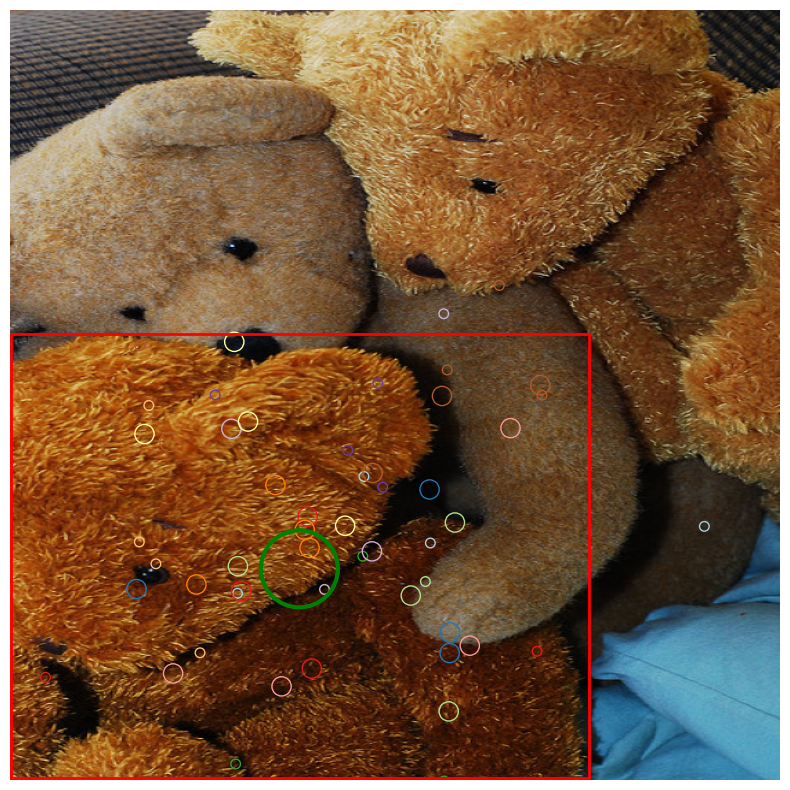

In [17]:
idx_decoder = 5
idx_batch = 0
idx_sample = 4

samples, targets = solver.val_dataloader.dataset[idx_sample]

results = inference(solver.model, samples, targets)

query_pos_list = get_query_list(results['topk_ind'])

deformable_points = results['deformable_points']

reference_points, sampling_points = get_deformable_points(deformable_points=deformable_points, images=samples)

print("reference_points", reference_points[idx_decoder].shape)
print("sampling_points", sampling_points[idx_decoder].shape)

plot_results(samples, results['pred_labels'][idx_batch, :1], 
            #  results['pred_boxes'][idx_batch, :1], 
             queries=query_pos_list[idx_batch][:1],
             reference_points=reference_points[idx_decoder][idx_batch, :1],
             sampling_points=sampling_points[idx_decoder][idx_batch, :1],
             )
# plot_results(samples, queries=query_pos_list[0][:11])

In [ ]:
idx_decoder = 5
idx_batch = 0
idx_sample = 4

for i in range(5000):
    samples, targets = solver.val_dataloader.dataset[i]

    results = inference(solver.model, samples, targets)

    query_pos_list = get_query_list(results['topk_ind'])

    deformable_points = results['deformable_points']

    reference_points, sampling_points = get_deformable_points(deformable_points=deformable_points, images=samples)

    plot_results(samples, results['pred_labels'][idx_batch, :1], 
                results['pred_boxes'][idx_batch, :1], 
                queries=query_pos_list[idx_batch][:1],
                #  reference_points=reference_points[idx_decoder][idx_batch, :1],
                sampling_points=sampling_points[idx_decoder][idx_batch, :1],
                )